# dp001 影片行為分析

使用資料集：user_data, dp001_review_plus, dp001_review, dp001_exam

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [8]:
# Read files
file_path = '2024初賽用開放資料/user_data.csv'
user = pd.read_csv(file_path)
user.drop(columns=['organization_id'], inplace=True)
user.drop(columns=['grade'], inplace=True)
user.drop(columns=['class'], inplace=True)
user.drop(columns=['seat'], inplace=True)

dp001_exam = pd.read_csv('2024初賽用開放資料/dp001_exam.csv')
dp001_review_plus = pd.read_csv('2024初賽用開放資料/dp001_review_plus.csv')
dp001_review = pd.read_csv('2024初賽用開放資料/dp001_review.csv')

user.head(5)

,user_sn,chinese_score,math_score,english_score
0,2697,80,52,86
1,4381,70,52,57
2,4561,77,56,100
3,6802,93,60,49
4,6828,83,52,89


# 數據探勘

In [19]:
import pandas as pd

# 1. 影片行為分類分析
view_action_counts = dp001_review_plus['view_action'].value_counts()

# 2. 觀看時間長度分析
# 透過 groupby 來計算不同 view_action 的平均時間戳差異
# 將資料依據 review_sn 分組，計算每個用戶每個行為類型的平均時間
dp001_review_plus['timestamp'] = dp001_review_plus['timestamp'].astype(float)  # 確保 timestamp 是數值型態
average_duration_by_action = dp001_review_plus.groupby('view_action')['timestamp'].mean()
print("各行為的平均觀看時間:\n", average_duration_by_action)

# 3. 播放至結束的比例
end_count = dp001_review_plus[dp001_review_plus['view_action'] == 'end'].shape[0]
total_count = dp001_review_plus.shape[0]
end_ratio = end_count / total_count
print("播放至結束的比例: {:.2%}".format(end_ratio))

# 4. 操作頻率與互動次數
# 計算每位用戶各種行為的次數
interaction_frequency = dp001_review_plus.groupby('review_sn')['view_action'].value_counts().unstack(fill_value=0)
print("每位用戶的互動次數:\n", interaction_frequency)

# 5. Turbo 模式的影響
turbo_usage = dp001_review_plus[dp001_review_plus['turbo'] == 1]
turbo_user_counts = turbo_usage['review_sn'].nunique()
print("使用 Turbo 模式的用戶數:", turbo_user_counts)
turbo_action_counts = turbo_usage['view_action'].value_counts()
print("在 Turbo 模式下的各行為次數:\n", turbo_action_counts)

# 6. 觀看行為的時間段分析
# 將 view_time 轉換為 datetime，並分析不同行為的時段分佈
dp001_review_plus['view_time'] = pd.to_datetime(dp001_review_plus['view_time'])
dp001_review_plus['hour'] = dp001_review_plus['view_time'].dt.hour
action_by_hour = dp001_review_plus.groupby(['view_action', 'hour']).size().unstack(fill_value=0)
print("不同行為在各時段的分佈:\n", action_by_hour)

# 額外：特定群體的篩選條件
# 篩選「深度觀看者」：包含多次 'play' 和 'end' 行為的用戶
deep_viewers = dp001_review_plus[(dp001_review_plus['view_action'] == 'play') | (dp001_review_plus['view_action'] == 'end')]
deep_viewers_count = deep_viewers['review_sn'].nunique()
print("深度觀看者數量:", deep_viewers_count)

# 篩選「快速瀏覽者」：主要行為為 'browse' 或 'turbo' 模式的用戶
browse_turbo_viewers = dp001_review_plus[(dp001_review_plus['view_action'] == 'browse') | (dp001_review_plus['turbo'] == 1)]
browse_turbo_viewers_count = browse_turbo_viewers['review_sn'].nunique()
print("快速瀏覽者數量:", browse_turbo_viewers_count)

# 篩選「專注用戶」：包含多次 'paused' 或 'fullscreenon' 行為的用戶
focused_viewers = dp001_review_plus[(dp001_review_plus['view_action'] == 'paused') | (dp001_review_plus['view_action'] == 'fullscreenon')]
focused_viewers_count = focused_viewers['review_sn'].nunique()
print("專注用戶數量:", focused_viewers_count)


各行為的平均觀看時間:
 view_action
browse           0.000000
chkptend       182.360575
chkptstart     182.418710
continue       174.900975
dragleft       147.566371
dragright      216.595806
dragstart      132.112705
end            370.590470
fuscreenoff    155.491724
fuscreenon      78.590775
normal         153.759277
note           201.809167
paused         167.557642
play           149.365406
question        64.850000
review         177.331489
slowdown       231.488519
speedup        103.665953
Name: timestamp, dtype: float64
播放至結束的比例: 3.49%
每位用戶的互動次數:
 view_action  browse  chkptend  chkptstart  continue  dragleft  dragright  \
review_sn                                                                  
97932045          1         0           0         0         0          0   
97932104          1         0           0         0         0          0   
97967614          1         1           1         0         0          0   
97968472          1         1           1         0         0      

# 各行為出現的次數

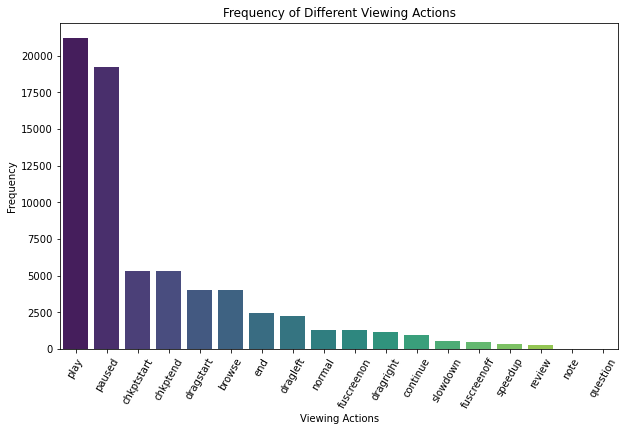

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# 各種行為的次數柱狀圖
plt.figure(figsize=(10, 6))
sns.barplot(x=view_action_counts.index, y=view_action_counts.values, palette="viridis")
plt.title("Frequency of Different Viewing Actions")
plt.xlabel("Viewing Actions")
plt.ylabel("Frequency")
plt.xticks(rotation=60)
plt.show()

# 不同行為在各時段的分佈

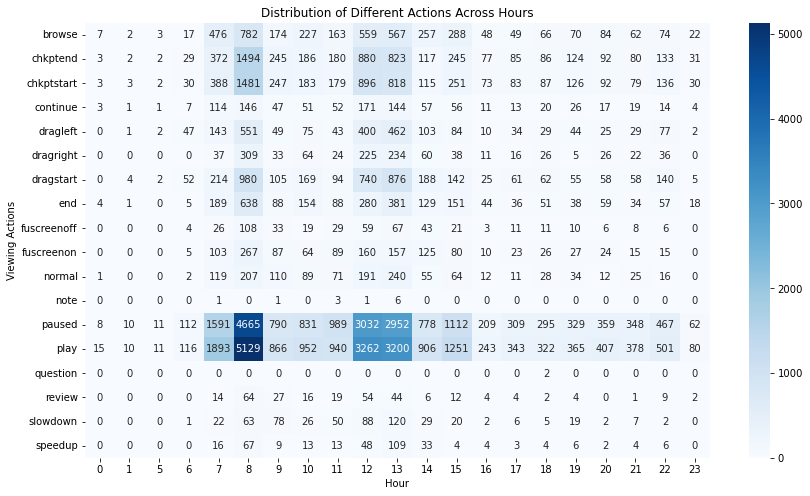

In [21]:
plt.figure(figsize=(14, 8))
sns.heatmap(action_by_hour, cmap="Blues", annot=True, fmt="d", cbar=True)
plt.title("Distribution of Different Actions Across Hours")
plt.xlabel("Hour")
plt.ylabel("Viewing Actions")
plt.show()

# 各影片觀看行為與在校成績的關聯

針對有各影片觀看行為的使用者，觀察其在校成績的平均值與所有user_data內的使用者相比，發現某些特定行為有明顯對應到在校成績較好的學生，且對於國、數、英各科都是

['browse' 'play' 'paused' 'normal' 'end' 'fuscreenon' 'fuscreenoff'
 'chkptstart' 'chkptend' 'continue' 'slowdown' 'dragstart' 'dragleft'
 'speedup' 'dragright' 'review' 'question' 'note']
[69.7, 69.7, 69.7, 69.1, 69.4, 70.9, 72.0, 69.1, 69.1, 68.5, 70.3, 69.7, 69.7, 69.0, 70.5, 70.5, 73.0, 70.6]
[48.3, 48.3, 48.3, 48.0, 47.8, 49.4, 50.5, 47.6, 47.6, 47.0, 48.8, 48.0, 48.0, 47.9, 48.3, 49.7, 60.0, 55.2]
[78.8, 78.8, 78.8, 78.4, 78.1, 78.6, 79.5, 77.7, 77.7, 77.0, 79.3, 78.4, 78.4, 79.2, 79.5, 78.4, 89.0, 79.2]


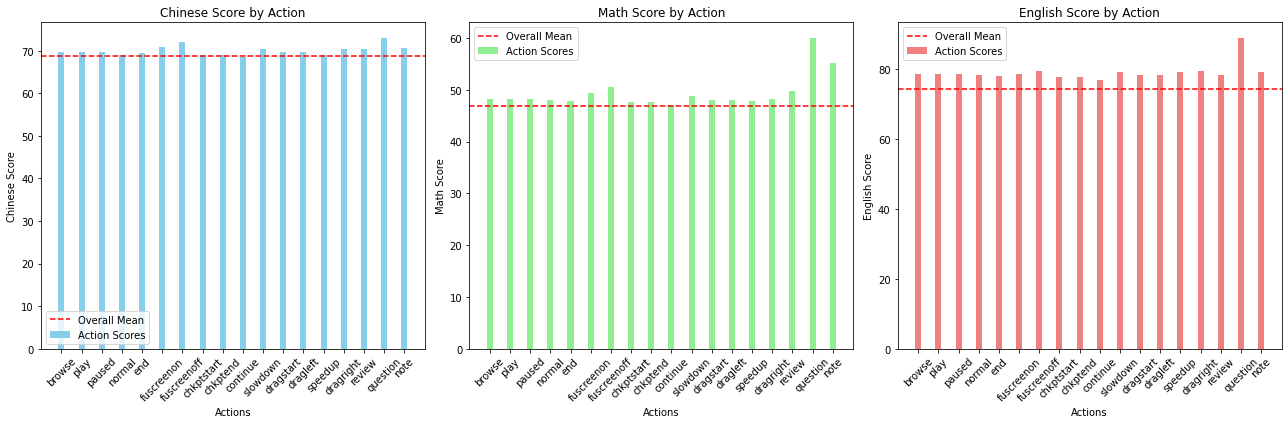

In [30]:
# Compare actions to school score
actions = dp001_review_plus['view_action'].unique()
print(actions)

user_all_chinese_mean = user['chinese_score'].describe().round(1)
user_all_math_mean = user['math_score'].describe().round(1)
user_all_english_mean = user['english_score'].describe().round(1)

data_chinese = []
data_math = []
data_english = []

for action in actions:
    # 獲取符合條件的 review_sn 列表
    review_sn_list = dp001_review_plus.loc[dp001_review_plus['view_action'] == action, 'review_sn']
    count = review_sn_list.value_counts()

    # 在 dp001_review 中篩選出符合 review_sn 的行
    result = dp001_review[dp001_review['review_sn'].isin(review_sn_list)]

    # 1. 獲取 result 中的 user_sn 列表
    user_sn_list = result['user_sn']

    # 2. 使用 .isin() 方法從 user_data 中篩選出對應的 user_sn 行
    review_highlight_user = user[user['user_sn'].isin(user_sn_list)]
    #print(review_highlight_user)

    review_highlight_user_stats = review_highlight_user.describe().round(1)
    data_chinese.append(review_highlight_user_stats['chinese_score']['mean'])
    data_math.append(review_highlight_user_stats['math_score']['mean'])
    data_english.append(review_highlight_user_stats['english_score']['mean'])
    #print("action:", action)
    #print(review_highlight_user_stats)
    
print(data_chinese)
print(data_math)
print(data_english)

# plotting
import matplotlib.pyplot as plt
import numpy as np

# 假設 dp001_review_plus, dp001_review, 和 user 是已經加載的 DataFrame
# 你已經獲得了 data_chinese, data_math, data_english 以及對應的 actions

# Set up the bar width
bar_width = 0.3
index = np.arange(len(actions))  # x-axis positions for each action

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot Chinese Scores
axes[0].bar(index, data_chinese, bar_width, color='skyblue', label='Action Scores')
axes[0].axhline(user_all_chinese_mean['mean'], color='red', linestyle='--', label='Overall Mean')
axes[0].set_xlabel('Actions')
axes[0].set_ylabel('Chinese Score')
axes[0].set_title('Chinese Score by Action')
axes[0].set_xticks(index)
axes[0].set_xticklabels(actions, rotation=45)
axes[0].legend()

# Plot Math Scores
axes[1].bar(index, data_math, bar_width, color='lightgreen', label='Action Scores')
axes[1].axhline(user_all_math_mean['mean'], color='red', linestyle='--', label='Overall Mean')
axes[1].set_xlabel('Actions')
axes[1].set_ylabel('Math Score')
axes[1].set_title('Math Score by Action')
axes[1].set_xticks(index)
axes[1].set_xticklabels(actions, rotation=45)
axes[1].legend()

# Plot English Scores
axes[2].bar(index, data_english, bar_width, color='lightcoral', label='Action Scores')
axes[2].axhline(user_all_english_mean['mean'], color='red', linestyle='--', label='Overall Mean')
axes[2].set_xlabel('Actions')
axes[2].set_ylabel('English Score')
axes[2].set_title('English Score by Action')
axes[2].set_xticks(index)
axes[2].set_xticklabels(actions, rotation=45)
axes[2].legend()

# Show the plots
plt.tight_layout()
plt.show()

# 模型建構

In [38]:
# 理論基礎：他人研究＆數據探勘
action_weights = {
    'slowdown': 0.1, #行為科學
    'speedup': 0.1, #行為科學
    'review': 0.2, #自我回饋
    'dragleft': 0.05, #學習深度
    'dragright': 0.05, #學習深度
    'dragstart': 0.1, #學習深度
    'note': 0.2, #行為科學
    'question': 0.15, #行為科學
}

# 計算每個用戶的行為加權分數
def calculate_behavior_score(row):
    score = 0
    for action, weight in action_weights.items():
        score += row.get(action, 0) * weight
    return score

In [41]:
# Merging dp001_review_plus and dp001_review based on 'review_sn' to get 'user_sn'
merged_reviews = pd.merge(dp001_review_plus, dp001_review[['review_sn', 'user_sn']], on='review_sn', how='left')

# Merging with user_data based on 'user_sn'
merged_reviews_user = pd.merge(merged_reviews, user[['user_sn']], on='user_sn', how='left')

# Merging with dp001_exam based on 'review_sn' to get exam data
final_merged = pd.merge(merged_reviews_user, dp001_exam[['review_sn', 'exam_sn', 'binary_res']], on='review_sn', how='left')

# 1. Count specific actions in dp001_review_plus for each user
actions_of_interest = ['slowdown', 'speedup', 'review', 'dragleft', 'dragright', 'dragstart', 'note', 'question']
action_counts = final_merged[final_merged['view_action'].isin(actions_of_interest)].groupby('user_sn')['view_action'].value_counts().unstack(fill_value=0)

# 2. Calculate exam statistics (total answers, correct answers, answer rate)
exam_stats = final_merged.groupby('user_sn').agg(
    total_answers=('binary_res', 'size'),
    correct_answers=('binary_res', 'sum')
)

# Calculate the answer rate (correct_answers / total_answers)
exam_stats['answer_rate'] = exam_stats['correct_answers'] / exam_stats['total_answers'] * 100

# Combine both the action counts and exam stats into one final dataframe
final_result = pd.concat([action_counts, exam_stats], axis=1)
final_result = final_result.dropna()

# Show the final result
final_result

,dragleft,dragright,dragstart,note,question,review,slowdown,speedup,total_answers,correct_answers,answer_rate
user_sn,,,,,,,,,,,
4561,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,14,0.0,0.000000
8634,5.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,412,33.0,8.009709
11303,1.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,406,48.0,11.822660
11312,23.0,0.0,26.0,1.0,0.0,32.0,75.0,6.0,3315,2117.0,63.861237
13328,19.0,16.0,40.0,0.0,0.0,2.0,1.0,5.0,700,225.0,32.142857
14503,249.0,6.0,262.0,0.0,0.0,21.0,39.0,1.0,5872,4721.0,80.398501
15995,196.0,11.0,229.0,0.0,0.0,8.0,4.0,1.0,6062,5108.0,84.262620
17422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,32,0.0,0.000000
20034,1.0,2.0,6.0,0.0,0.0,0.0,3.0,7.0,750,139.0,18.533333


In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

'''
behavior_columns = action_counts.columns  # These columns correspond to view_action counts

final_result[behavior_columns] = final_result[behavior_columns].applymap(lambda x: 1 if x > 1 else x)
'''

X = final_result.drop(columns=['correct_answers'])  # 特徵
X = X.drop(columns=['answer_rate'])
y = final_result['answer_rate']  # 目標變量：答對題數

X['behavior_score'] = X.apply(calculate_behavior_score, axis=1)

# 3.1 切分訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3.2 建立模型
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 3.3 訓練模型
model.fit(X_train, y_train)

# 3.4 預測並評估模型
y_pred = model.predict(X_test)
#print("y_train:", y_train)
print("y_pred:", y_pred)

# 計算 MAE (Mean Absolute Error)
mae = mean_absolute_error(y_test, y_pred)
print(f"模型的平均絕對誤差 (MAE): {mae:.4f}")

y_pred: [ 5.9577399  82.11653453 82.40769254 18.45274799 73.33052432 74.62766757
 63.40674559 76.2934086  14.14063774 80.06457501 76.83832338 66.9972119 ]
模型的平均絕對誤差 (MAE): 6.8630
